# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [4]:
!mkdir data

In [5]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31287    0 31287    0     0  92995      0 --:--:-- --:--:-- --:--:-- 92839


In [6]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70146    0 70146    0     0   182k      0 --:--:-- --:--:-- --:--:--  183k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

[nltk_data] Downloading package punkt to /Users/kenny/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kenny/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/Users/kenny/code/ai/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/Users/kenny/code/ai/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/Users/kenny/code/ai/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [7]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [8]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [9]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 66)

We can save and load our knowledge graphs as follows.

In [10]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 66)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [11]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [12]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

**Answer:** 

- SingleHopSpecificQuerySynthesizer (50%): Simple questions needing just one fact ("What was Meta's revenue in 2023?")
- MultiHopAbstractQuerySynthesizer (25%): Big-picture questions requiring connecting multiple concepts ("How has AI safety evolved?")
- MultiHopSpecificQuerySynthesizer (25%): Detail-oriented questions needing multiple specific facts ("Compare Meta's and Google's model sizes and training costs")


Finally, we can use our `TestSetGenerator` to generate our testset!

In [13]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,Wht is OpenAI?,[Code may be the best application The ethics o...,"A year ago, the only organization that had rel...",single_hop_specifc_query_synthesizer
1,Wht are the challenges and potential solutions...,[Based Development As a computer scientist and...,The challenges of using ChatGPT in AI-driven s...,single_hop_specifc_query_synthesizer
2,What were the significant advancements in Arti...,[Simon Willison’s Weblog Subscribe Stuff we fi...,2023 was a breakthrough year for Large Languag...,single_hop_specifc_query_synthesizer
3,what's the deal with Llama 2 and how you run i...,[easy to follow. The rest of the document incl...,You can run Llama 2 on your own Mac using LLM ...,single_hop_specifc_query_synthesizer
4,How has the competitive landscape for GPT-4 le...,[Prompt driven app generation is a commodity a...,"Over the past year, the competitive landscape ...",single_hop_specifc_query_synthesizer
5,What are the ethical concerns associated with ...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns associated with the train...,multi_hop_abstract_query_synthesizer
6,How has OpenAI contributed to the advancements...,[<1-hop>\n\nCode may be the best application T...,OpenAI has played a significant role in the ad...,multi_hop_abstract_query_synthesizer
7,How do the ethics of training data impact the ...,[<1-hop>\n\nCode may be the best application T...,The ethics of training data significantly impa...,multi_hop_abstract_query_synthesizer
8,What advancements have been made by Mistral in...,[<1-hop>\n\nCode may be the best application T...,Mistral has made significant advancements in t...,multi_hop_specific_query_synthesizer
9,How did the advancements in GPT-4 and other mo...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, advancements in GPT-4 and other model...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [14]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [22]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wut has Meta dun in the feeld of LLMs this yeer?,[Code may be the best application The ethics o...,"In February, Meta released Llama, and in July,...",single_hop_specifc_query_synthesizer
1,What significant event related to AI ethics oc...,[Based Development As a computer scientist and...,"In September last year, the term 'prompt injec...",single_hop_specifc_query_synthesizer
2,Whaat are the key highlights from Simon Willis...,[Simon Willison’s Weblog Subscribe Stuff we fi...,Simon Willison's Weblog highlights that 2023 w...,single_hop_specifc_query_synthesizer
3,What role does Stanford Alpaca play in the dev...,[easy to follow. The rest of the document incl...,Stanford Alpaca is associated with the acceler...,single_hop_specifc_query_synthesizer
4,What are the ethical concerns associated with ...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns associated with the gulli...,multi_hop_abstract_query_synthesizer
5,Why are Large Language Models (LLMs) considere...,[<1-hop>\n\nCode may be the best application T...,Large Language Models (LLMs) are considered bl...,multi_hop_abstract_query_synthesizer
6,What are the ethical concerns related to the g...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns related to the gullibilit...,multi_hop_abstract_query_synthesizer
7,How do the ethics of AI and the gullibility of...,[<1-hop>\n\nCode may be the best application T...,The ethics of AI and the gullibility of langua...,multi_hop_abstract_query_synthesizer
8,How has the development of models surpassing G...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the development of models surpassing ...",multi_hop_specific_query_synthesizer
9,How does the training efficiency of DeepSeek v...,[<1-hop>\n\nday after that. DeepSeek v3 is a h...,"DeepSeek v3, a 685B parameter model, is one of...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [15]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [16]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [17]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [19]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [20]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [21]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [22]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [23]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [24]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [57]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents are infuriatingly vague AI systems that are often thought of as capable of acting on your behalf, similar to a travel agent. There are differing interpretations of what "agents" are, with some viewing them as AI that can run tools in a loop to solve problems. However, the term lacks a clear and widely understood definition, and there are few examples of such systems running in production despite prototypes. The concept of agents is still seen as perpetually "coming soon."'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [25]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [26]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: basic question-answering evaluator that checks if the model's response correctly answers the given question.
- `labeled_helpfulness_evaluator`: specifically looks at how helpful the response is to the user, comparing it against a reference answer.
- `dope_or_nope_evaluator`: evaluates responses based on their "coolness factor" - checking if they're engaging and fun while still being informative.

## LangSmith Evaluation

In [27]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'sunny-cushion-98' at:
https://smith.langchain.com/o/c63c3df1-e791-438b-8581-69fbd751928b/datasets/5dab38a8-7d50-4f30-8a57-f09ea1a16a77/compare?selectedSessions=c2c8a3ee-d106-4feb-851f-85247c0dbf6d




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How do the environmental impacts and training ...,The context does not provide specific details ...,None,"The Llama 3.1 model required 30,840,000 GPU ho...",0,0,0,4.201695,428a50a4-e9ec-46ac-82d5-53de25964e86,6c485c8c-8b93-4da4-9c37-f4483ed527ab
1,What advancements in Claude 3 series and prici...,The Claude 3 series saw significant advancemen...,None,"The Claude 3 series, launched by Anthropic in ...",1,0,1,5.064842,9a0d317a-5e3b-4785-a190-bc36dd5f5314,50843bcf-bab7-4b83-b944-1dd7974b65e5
2,What are the challenges and ethical concerns a...,The challenges and ethical concerns associated...,None,The challenges associated with the use of LLMs...,0,0,0,5.265765,c06e325b-eedf-4943-b4cb-a69cbef44a28,5c0eb8fe-0af5-4545-8701-f101efade7d6
3,What are the challenges and potential solution...,The challenges related to the gullibility of L...,None,The challenges related to the gullibility of L...,1,1,0,2.904020,2a873150-961e-41f5-bb6a-c4cb2eca5b16,ff9e387b-31e8-4c7c-a16b-990365f69c8d
4,How OpenAI's role in the development of LLMs a...,OpenAI is mentioned as a significant player in...,None,OpenAI has played a significant role in the de...,1,0,0,3.661222,c3e4f509-d921-4118-8b24-075012929ae0,a9a8264b-1f3d-484d-a0d9-a553ab5e1712
5,How has the development of fine-tuning models ...,The development of fine-tuning models has made...,None,The development of fine-tuning models has sign...,1,1,1,3.958089,4f5c43f3-70e5-49c9-ad01-44484d8fe31a,e2120f1b-ab2b-4b1f-84bd-4dcb7f7c76e8
6,How has OpenAI contributed to the development ...,OpenAI has played a pioneering role in the dev...,None,OpenAI has played a significant role in the de...,1,0,0,12.149411,e264cefd-603b-49c6-9d6c-e936707563b0,69c10817-22fa-41dd-bd3d-9972e79bfb34
7,"How has the environmental impact of AI, partic...",The context indicates mixed developments regar...,None,"The environmental impact of AI, especially con...",0,0,0,2.971111,58c7af02-ff61-42aa-b7d5-dd3dc5cb542a,5214986f-9598-48dc-a3df-6ea2609a023e
8,What insights did Simon Willison share about A...,Simon Willison shared that 2023 was a breakthr...,None,Simon Willison shared insights on AI developme...,0,0,1,3.465469,d659b49c-92de-4f22-bdee-bf68a262ee9c,28ed6080-eb0a-4f11-bbd1-d53c2b284aa9
9,What were the key developments in Large Langua...,"In 2023, key developments in Large Language Mo...",None,2023 was the breakthrough year for Large Langu...,1,1,1,3.469691,caea5e41-d6c5-4ed6-a027-e9d849c51754,2cc4e60e-bfd9-4b0f-bc9d-75e3b2b757a4


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [28]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [29]:
rag_documents = docs

In [30]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

**Answer:**
1. Larger chunks provide more context in each piece, helping the model better understand the full meaning
2. But larger chunks also mean fewer total chunks, which could miss important details that get split across chunks or provide for difficult to pinpoint references
3. The chunk size needs to balance between having enough context while still being granular enough for accurate retrieval

In [31]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

**Answer:**

1. Higher dimensional embeddings means richer semantic representation
2. Increased compute and API costs is the tradeoff

In [32]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [33]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [34]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [35]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Yo, "agents" are like those elusive AI systems that are supposed to act on your behalf, kinda like a digital travel agent or an assistant, but the term is super vague. You\'ve got folks thinking they\'re autonomous tools, while others see them as LLMs doing their thing in a loop to solve problems. But here’s the kicker: there\'s a lot of confusion about what it really means, and until we solve the whole gullibility issue with AI, these dreamy agents might just be "coming soon" forever!'

Finally, we can evaluate the new chain on the same test set!

In [36]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'tart-quill-53' at:
https://smith.langchain.com/o/c63c3df1-e791-438b-8581-69fbd751928b/datasets/5dab38a8-7d50-4f30-8a57-f09ea1a16a77/compare?selectedSessions=67b644d6-60b1-4878-ab8a-1aaece38a5fa




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How do the environmental impacts and training ...,"Yo, so the environmental impacts and training ...",None,"The Llama 3.1 model required 30,840,000 GPU ho...",0,0,1,4.106207,428a50a4-e9ec-46ac-82d5-53de25964e86,d2606afe-7018-464e-8dfd-0adde96eb5bf
1,What advancements in Claude 3 series and prici...,"Yo, in 2024, the Claude 3 series from Anthropi...",None,"The Claude 3 series, launched by Anthropic in ...",1,0,1,5.809427,9a0d317a-5e3b-4785-a190-bc36dd5f5314,e362a306-34aa-4cb9-a5be-89d442780f23
2,What are the challenges and ethical concerns a...,"Yo, let’s break it down! The challenges with L...",None,The challenges associated with the use of LLMs...,1,1,1,4.044841,c06e325b-eedf-4943-b4cb-a69cbef44a28,a442f71b-61ae-4a2d-8e6d-d915d30ee45b
3,What are the challenges and potential solution...,"Yo, here's the lowdown on the challenges and p...",None,The challenges related to the gullibility of L...,1,1,1,5.045393,2a873150-961e-41f5-bb6a-c4cb2eca5b16,13e6c394-7d95-44b6-a500-0a8e37193811
4,How OpenAI's role in the development of LLMs a...,"Yo, it’s all about that OpenAI hustle in the L...",None,OpenAI has played a significant role in the de...,1,"Based on these steps, while the submission pro...",1,5.812333,c3e4f509-d921-4118-8b24-075012929ae0,f5bb1082-2cfd-4c6c-89c3-0cb7710f01a3
5,How has the development of fine-tuning models ...,"Yo, the whole scene has exploded! Fine-tuning ...",None,The development of fine-tuning models has sign...,1,0,1,6.255542,4f5c43f3-70e5-49c9-ad01-44484d8fe31a,95e5d7f3-20f4-4956-ad4c-9f86a70d941b
6,How has OpenAI contributed to the development ...,"Yo, here's the lowdown on OpenAI's ride in the...",None,OpenAI has played a significant role in the de...,1,0,1,6.833159,e264cefd-603b-49c6-9d6c-e936707563b0,7e988d42-ddcd-42f0-81f6-2806a55279a1
7,"How has the environmental impact of AI, partic...","Yo, the environmental scene for AI has seen so...",None,"The environmental impact of AI, especially con...",1,0,1,5.560699,58c7af02-ff61-42aa-b7d5-dd3dc5cb542a,6ee4c3a9-7260-4cff-800d-79cfe7766ed8
8,What insights did Simon Willison share about A...,"Yo, Simon Willison dropped some serious knowle...",None,Simon Willison shared insights on AI developme...,0,0,1,3.720456,d659b49c-92de-4f22-bdee-bf68a262ee9c,7e4fc697-6041-4622-a09f-95bced5415fc
9,What were the key developments in Large Langua...,"Yo, check it! In 2023, Large Language Models (...",None,2023 was the breakthrough year for Large Langu...,1,1,1,5.084770,caea5e41-d6c5-4ed6-a027-e9d849c51754,994ad9de-52f7-4c51-96f5-9e5daf3ea7a0


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

The dopeness score was certainly due to the updated prompt that we added, the other two improvements were likely because of the combination of our larger embedding model and increased chunk size. Although to know for sure, we would need to adjust one factor at a time and view the evaluations for each, trying to incrementally work towards evaluations we are happy with with each change.

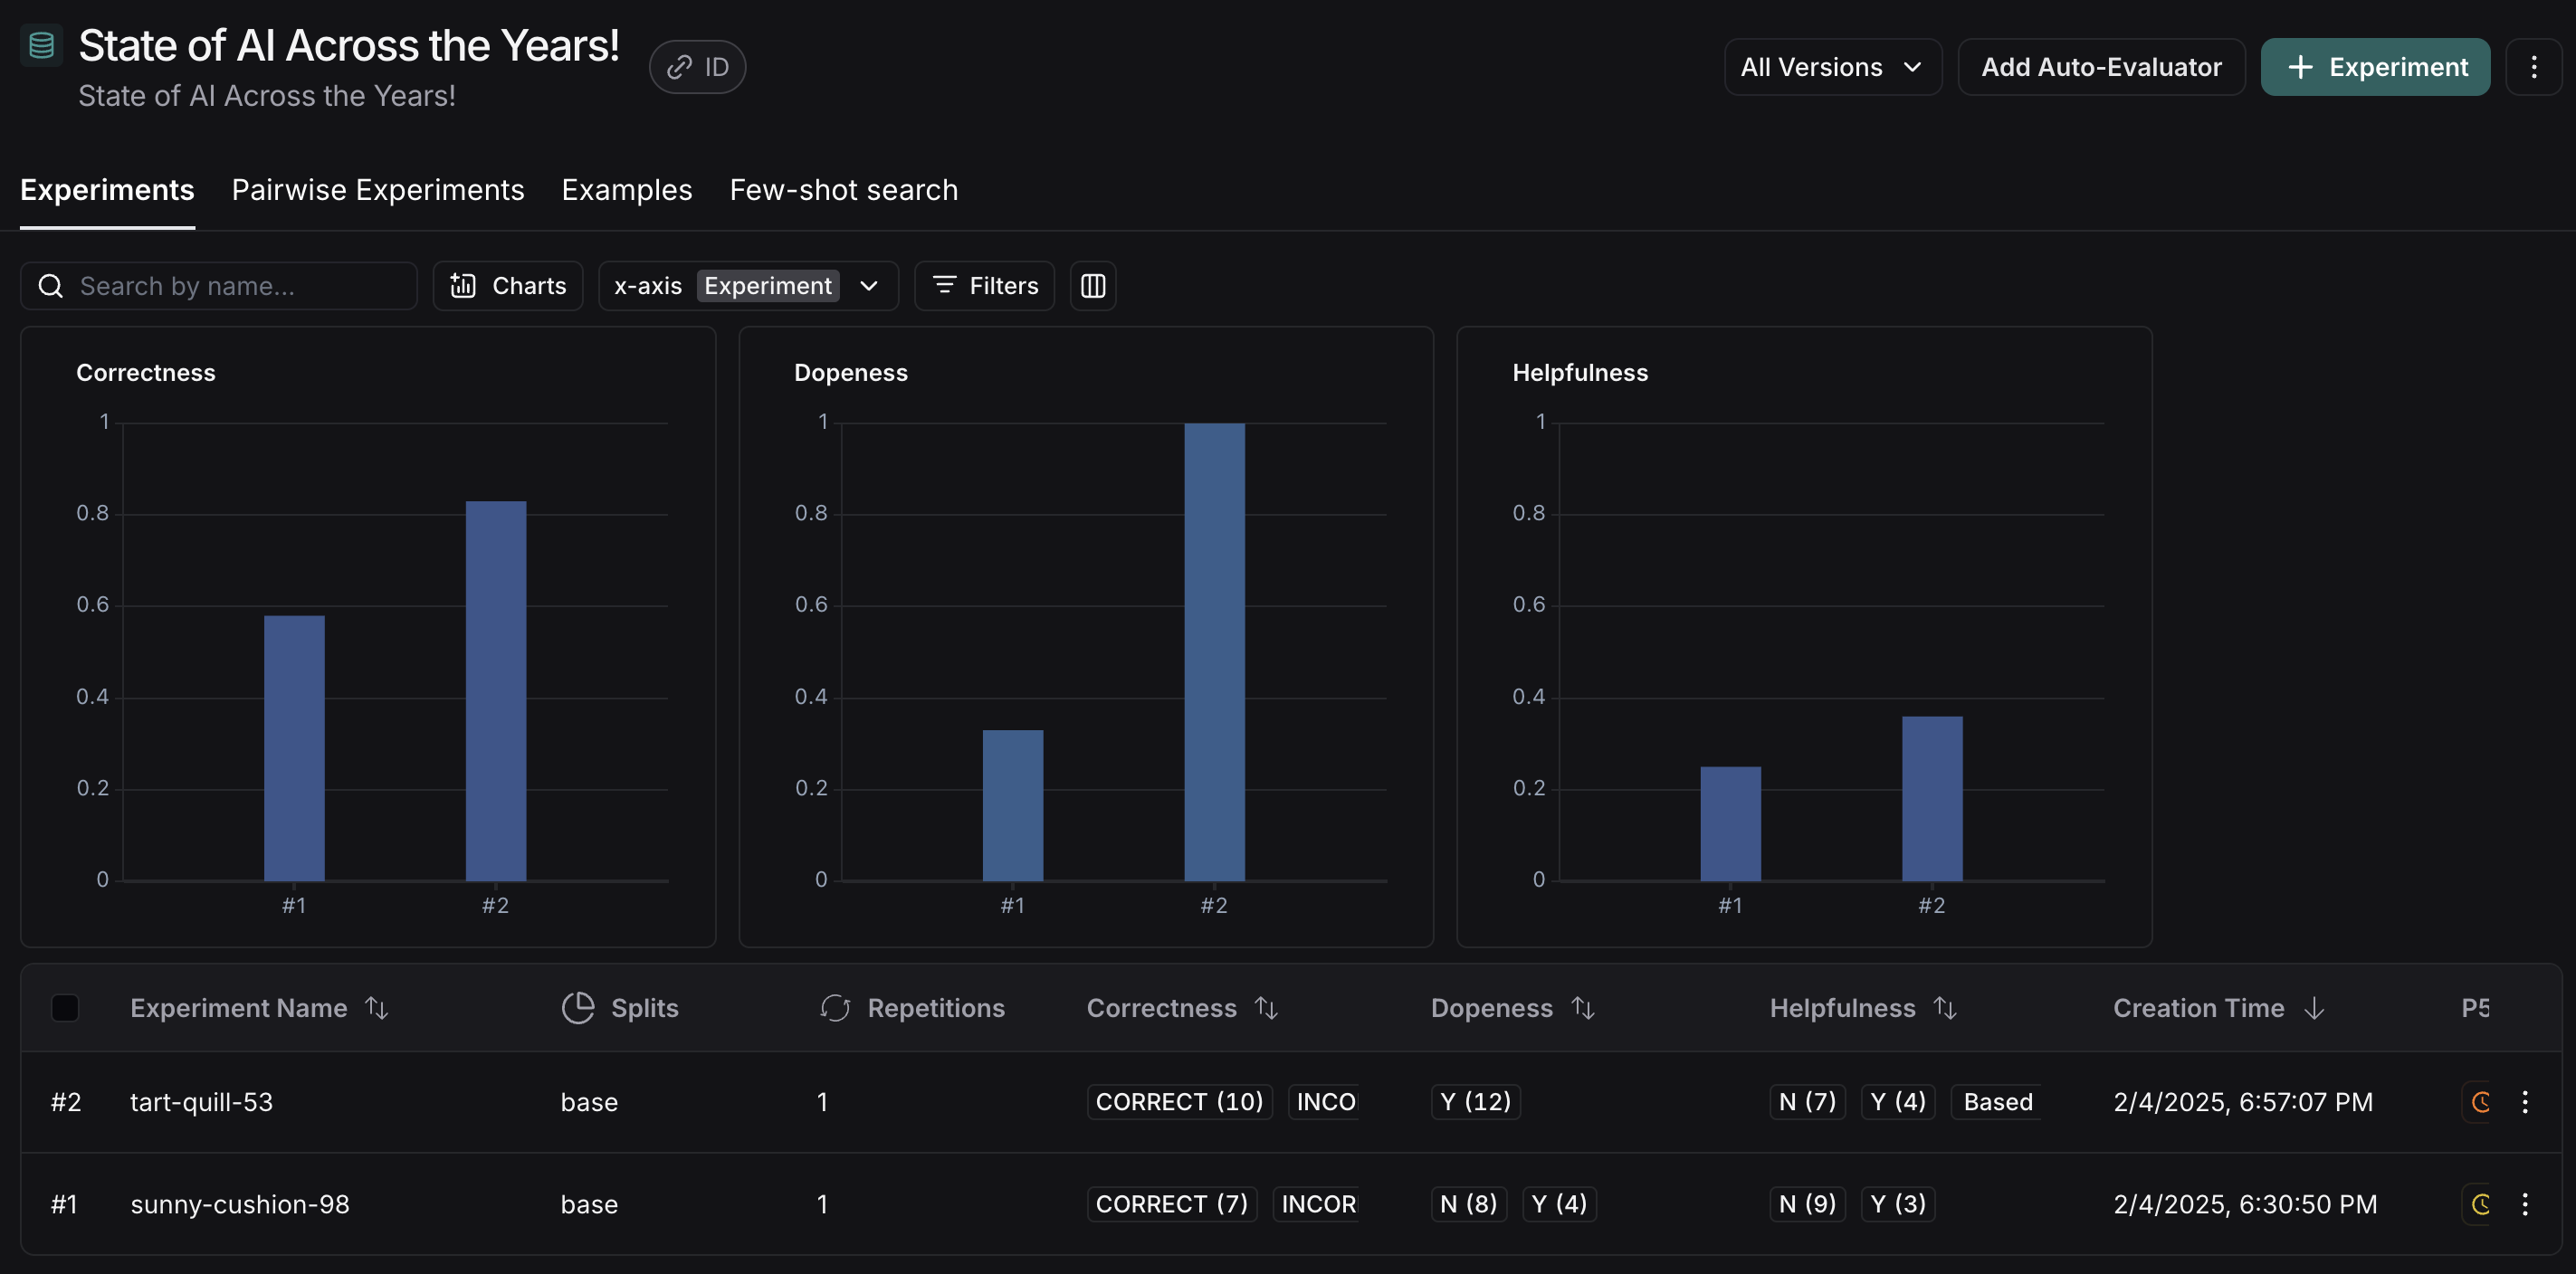